In [45]:
%%capture
! pip install -r requirements.txt

In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import shutil
import json

In [47]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
device

'mps'

In [48]:
# -- Create the file structure
def make_file_structure():
    base_dir = "."
    dirs = ["images/train", "images/val", "labels/train", "labels/val"]

    for d in dirs:
        os.makedirs(os.path.join(base_dir, d), exist_ok=True)

# -- Add data to images folder
def add_images_to_file(src, dest, start=0, end=None, train=True):
    src_path = os.path.join(src, "data")

    if train:
        dest_path = os.path.join(dest, "train")
    else:
        dest_path = os.path.join(dest, "val")

    # -- Remove existing folder from previous run and make a new one
    if os.path.exists(dest_path):
        shutil.rmtree(dest_path)
    os.makedirs(dest_path, exist_ok=True)

    # Collecting all the image files
    files = [f for f in os.listdir(src_path) if f.endswith((".jpg", ".png"))]
    files = sorted(files)
    
    # If end is None, process all files
    if end is None:
        end = len(files)
    
    files = files[start:end]

    # -- Copying the selected files
    for file in files:
        shutil.copy(os.path.join(src_path, file), os.path.join(dest_path, file))
    
    print(f"Copied {len(files)} images to {dest_path}")
    return files 

# -- Adding labels to label folder
def add_labels_to_file(src, dest, image_files=None, train=True):
    json_file = os.path.join(src, "coco.json")

    with open(json_file, 'r') as f:
        data = json.load(f)
    
    annotations = data["annotations"]
    images = {img["id"]: img for img in data["images"]}

    # Create a mapping from category_id to index
    categories = {cat["id"]: idx for idx, cat in enumerate(data["categories"])}

    # Create destination directory if it doesn't exist
    label_dir = os.path.join(dest, "train" if train else "val")
    os.makedirs(label_dir, exist_ok=True)
    
    # If image_files is provided, filter to only those images
    if image_files is not None:
        image_filenames = set(image_files)
        # Filter images dict to only include the specified files
        images = {img_id: img_info for img_id, img_info in images.items() 
                  if os.path.basename(img_info["file_name"]) in image_filenames}
    
    # Group annotations by image_id (only for filtered images)
    img_anno = {}
    for anno in annotations:
        img_id = anno["image_id"]
        if img_id in images:
            if img_id not in img_anno:
                img_anno[img_id] = []
            img_anno[img_id].append(anno)
    
    # Process each image
    processed = 0
    for img_id, annos in img_anno.items():
        img_info = images[img_id]
        img_width = img_info["width"]
        img_height = img_info["height"]
        img_filename = img_info["file_name"]

        # Extract just the filename
        base_filename = os.path.basename(img_filename)
        
        # Create label files
        label_filename = os.path.splitext(base_filename)[0] + ".txt"
        label_path = os.path.join(dest, "train" if train else "val", label_filename)

        # Write in YOLO format
        with open(label_path, "w") as l:
            for anno in annos:
                category_id = anno["category_id"]
                
                if category_id not in categories:
                    print(f"Warning: Category {category_id} not found")
                    continue
                    
                class_idx = categories[category_id]

                bbox = anno["bbox"]

                x, y, w, h = bbox
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                w_norm = w / img_width
                h_norm = h / img_height

                l.write(f"{class_idx} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")
        
        processed += 1
    
    print(f"Processed {processed} label files in {label_dir}")


make_file_structure()

# Try with the first 10 images for both train and val
# -- Mess around with end to change number of images processed
train_files = add_images_to_file("./images_thermal_train", "./images", start=0, end=10, train=True)
add_labels_to_file("./images_thermal_train", "./labels", image_files=train_files, train=True)

val_files = add_images_to_file("./images_thermal_val", "./images", start=0, end=10, train=False)
add_labels_to_file("./images_thermal_val", "./labels", image_files=val_files, train=False)

Copied 10 images to ./images/train
Processed 10 label files in ./labels/train
Copied 10 images to ./images/val
Processed 10 label files in ./labels/val


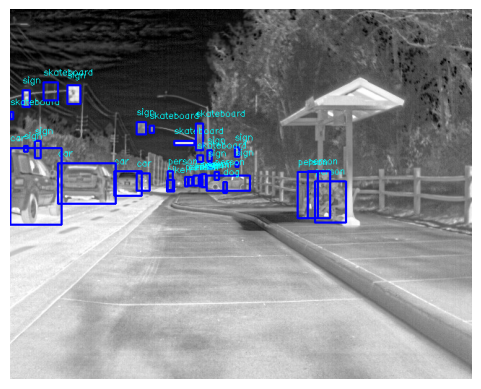

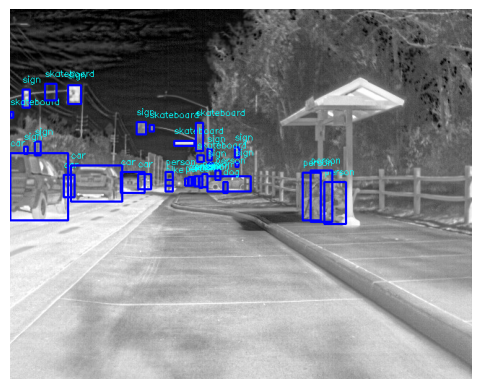

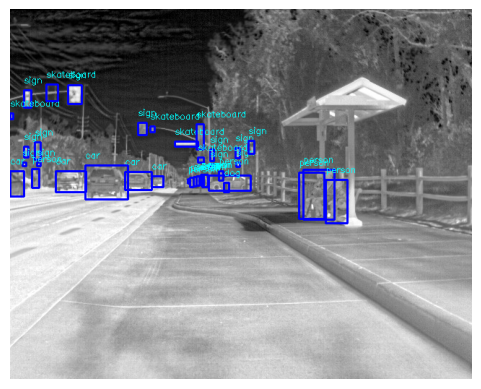

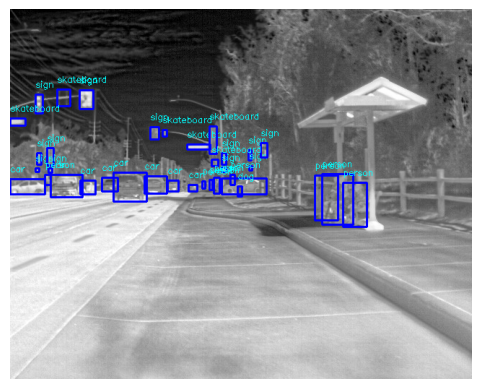

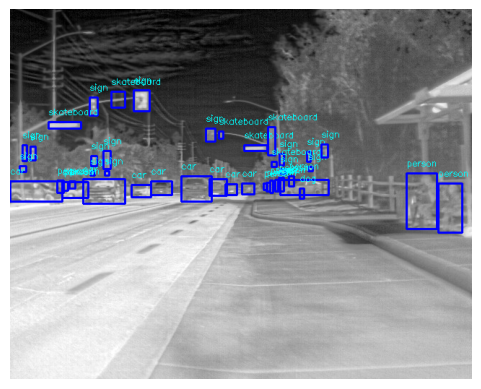

In [49]:
#-- Visualizing the first image and annotations
import cv2
import yaml

with open("config.yml", "r") as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml["names"]

#Sort files to ensure matching images and files
img_files = sorted(os.listdir('./images/train'))
label_files = sorted(os.listdir('./labels/train'))

for i in range(5):
    first_img_path = "./images/train/" + img_files[i]
    first_img = cv2.imread(first_img_path)


    first_img_anot_path = "./labels/train/" + label_files[i]

    with open(first_img_anot_path, 'r') as f:
        annot = f.readlines()
        for cls, xc, yx, w, h in [line.strip().split() for line in annot]:
            cv2.rectangle(first_img, 
                        (int((float(xc) - float(w)/2) * first_img.shape[1]), int((float(yx) - float(h)/2) * first_img.shape[0])),
                        (int((float(xc) + float(w)/2) * first_img.shape[1]), int((float(yx) + float(h)/2) * first_img.shape[0])),
                        (255, 0, 0), 2)
            label = class_names[int(cls)]
            cv2.putText(first_img, label,
                        (int((float(xc) - float(w)/2) * first_img.shape[1]), int((float(yx) - float(h)/2) * first_img.shape[0]) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
            
    plt.imshow(cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB))
    plt.axis(False)
    plt.show()

# Model

In [50]:
EPOCHS=20
BATCH_SIZE=16
IMG_SIZE=640

from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="config.yml",
    imgsz=IMG_SIZE,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    device=device,
    patience=5,
    exist_ok=True,
    project="runs_thermal",
    name="yolov8s_full"
)

New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.175 🚀 Python-3.12.11 torch-2.7.1 MPS (Apple M4 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=config.yml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_full, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

train: Scanning /Users/FreemanYiu/Downloads/AVL_Thermal/labels/train... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 2494.98it/s]

train: New cache created: /Users/FreemanYiu/Downloads/AVL_Thermal/labels/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2718.7±761.0 MB/s, size: 104.2 KB)



val: Scanning /Users/FreemanYiu/Downloads/AVL_Thermal/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 2908.07it/s]

val: New cache created: /Users/FreemanYiu/Downloads/AVL_Thermal/labels/val.cache
Plotting labels to runs_thermal/yolov8s_full/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs_thermal/yolov8s_full
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.29G      2.012      4.834      1.235        601        640: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.25G      2.101      4.843      1.251        519        640: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       3.3G      1.932      4.822      1.233        419        640: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       3.3G      2.045      4.802      1.198        701        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       3.3G      1.953      4.804      1.216        698        640: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       3.3G      1.981      4.786      1.168        827        640: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.36G      1.844      4.665      1.148        448        640: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       3.3G      1.879      4.683      1.166        557        640: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.36G      1.885      4.693      1.153        392        640: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       3.3G      1.839      4.645      1.102        882        640: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         10        200          0          0          0          0


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.36G      1.847      4.563      1.075        391        640: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.36G      1.663      4.464      1.046        367        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.36G      1.794        4.5      1.084        379        640: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.36G      1.669      4.414      1.034        371        640: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         10        200          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.36G      1.837      4.456      1.033        396        640: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         10        200        0.2    0.00351      0.102     0.0813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.36G      1.798      4.411      1.043        380        640: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         10        200        0.2    0.00702      0.104     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.36G      1.627       4.31     0.9962        375        640: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         10        200      0.167    0.00877     0.0885     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.36G      1.734      4.304      1.013        383        640: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         10        200      0.167    0.00877     0.0885     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.35G       1.69      4.291      1.046        362        640: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         10        200      0.178      0.014     0.0961     0.0757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       3.3G      1.775      4.288       1.02        381        640: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         10        200      0.178      0.014     0.0961     0.0757



20 epochs completed in 0.010 hours.
Optimizer stripped from runs_thermal/yolov8s_full/weights/last.pt, 6.2MB
Optimizer stripped from runs_thermal/yolov8s_full/weights/best.pt, 6.2MB

Validating runs_thermal/yolov8s_full/weights/best.pt...
Ultralytics 8.3.175 🚀 Python-3.12.11 torch-2.7.1 MPS (Apple M4 Pro)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


                   all         10        200        0.2    0.00702      0.104     0.0904
                person         10         51          0          0          0          0
                  bike          4          6          0          0          0          0
                   car         10        114          1     0.0351      0.518      0.452
                   dog          4          4          0          0          0          0
            skateboard         10         25          0          0          0          0
Speed: 0.4ms preprocess, 6.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs_thermal/yolov8s_full


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x42b788fb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
      

In [51]:
# -- Evaulation

metrics = model.val()
metrics = vars(metrics)

for k,v in metrics.items():
    print(f"{k}: {v}")

Ultralytics 8.3.175 🚀 Python-3.12.11 torch-2.7.1 MPS (Apple M4 Pro)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2433.8±420.8 MB/s, size: 106.0 KB)


val: Scanning /Users/FreemanYiu/Downloads/AVL_Thermal/labels/val.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


                   all         10        200        0.2    0.00702      0.104     0.0904
                person         10         51          0          0          0          0
                  bike          4          6          0          0          0          0
                   car         10        114          1     0.0351      0.518      0.452
                   dog          4          4          0          0          0          0
            skateboard         10         25          0          0          0          0
Speed: 2.3ms preprocess, 6.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs_thermal/yolov8s_full
names: {0: 'person', 1: 'bike', 2: 'car', 3: 'motor', 4: 'bus', 5: 'train', 6: 'truck', 7: 'light', 8: 'hydrant', 9: 'sign', 10: 'dog', 11: 'skateboard', 12: 'stroller', 13: 'scooter', 14: 'other vechicle'}
box: ultralytics.utils.metrics.Metric object with attributes:

all_ap: array([[          0,           0,           0,           0,    


image 1/10 /Users/FreemanYiu/Downloads/AVL_Thermal/images/val/video-57kWWRyeqqHs3Byei-frame-000816-b6tuLjNco8MfoBs3d.jpg: 512x640 (no detections), 52.4ms
image 2/10 /Users/FreemanYiu/Downloads/AVL_Thermal/images/val/video-57kWWRyeqqHs3Byei-frame-000831-dsrhuE2hoMsERqDZT.jpg: 512x640 (no detections), 12.5ms
image 3/10 /Users/FreemanYiu/Downloads/AVL_Thermal/images/val/video-57kWWRyeqqHs3Byei-frame-000846-9A58EHiNDm7amc4Mq.jpg: 512x640 (no detections), 12.6ms
image 4/10 /Users/FreemanYiu/Downloads/AVL_Thermal/images/val/video-57kWWRyeqqHs3Byei-frame-000861-FnEJHM4xCbiFuLD5q.jpg: 512x640 (no detections), 12.6ms
image 5/10 /Users/FreemanYiu/Downloads/AVL_Thermal/images/val/video-57kWWRyeqqHs3Byei-frame-000876-JtZgCe4rmRSco7TRQ.jpg: 512x640 (no detections), 12.7ms
image 6/10 /Users/FreemanYiu/Downloads/AVL_Thermal/images/val/video-57kWWRyeqqHs3Byei-frame-000891-yMxkpA3QbaX4J8mQd.jpg: 512x640 (no detections), 12.6ms
image 7/10 /Users/FreemanYiu/Downloads/AVL_Thermal/images/val/video-57kWWRy

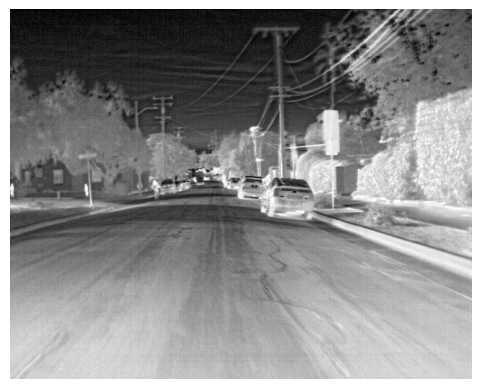

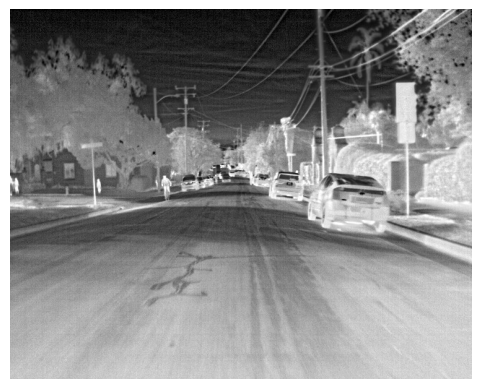

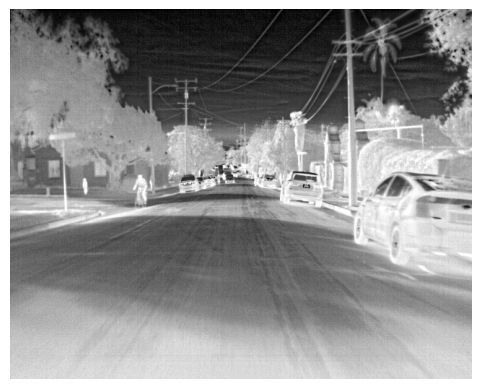

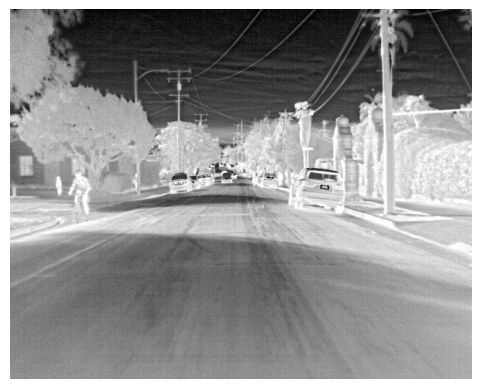

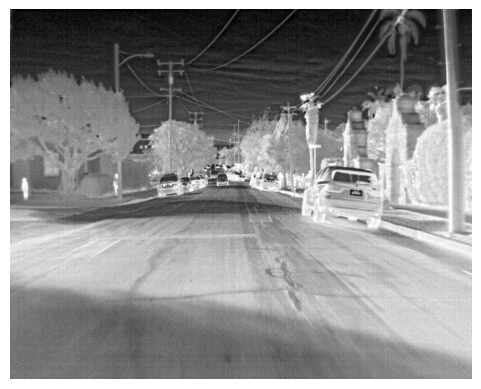

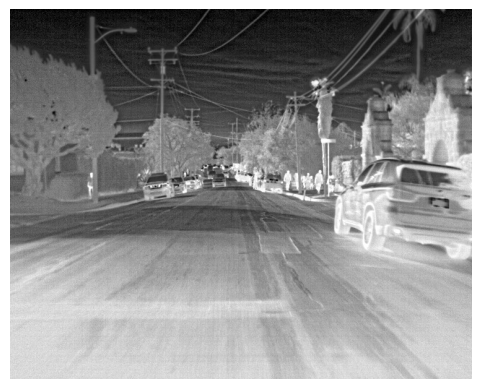

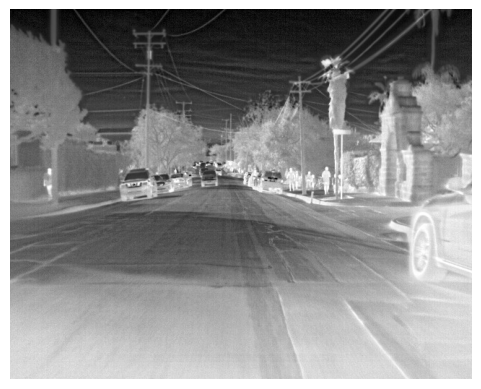

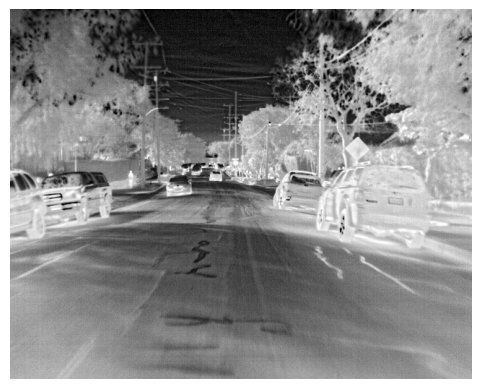

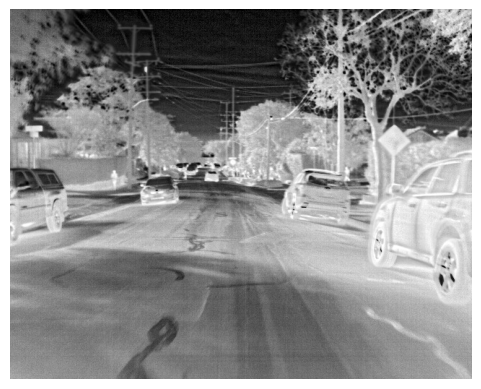

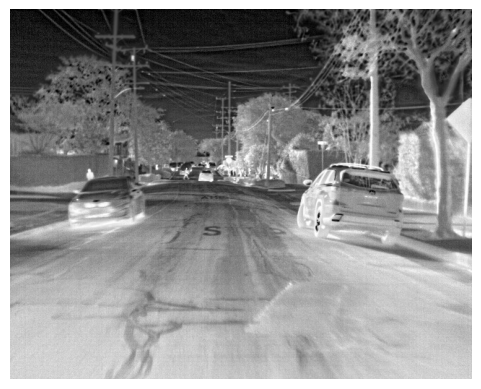

In [ ]:
# -- Inference

results = model.predict(source="images/val", save=True, device=device)
print(f"Inference saved to: {results[0].save_dir}")

In [ ]:
# -- Save Model
model.export(format="onnx")